# Week 5 worksheet: Matrix methods for the solution of Elliptic equations - Simplified Pipeline

This worksheet contains a number of exercises covering only the numerical aspects of the course. 

#### Suggested reading

You will see lists of links to further reading and resources throughout the worksheets, in sections titled **Learn more:**. These will include links to the Python documentation on the topic at hand, or links to relevant book sections or other online resources. Unless explicitly indicated, these are not mandatory reading, although of course we strongly recommend that you consult them!

##### This a solved example to go through that will help you understand how the matrix assembly works. It is a simplified code that shows step by step the assembly of the matrices for the system of equations along with constructing the grid in a pipeline. The system of equations, when solved will give the numerical solution of the Laplace equation at every interior point.
This example does not involve the use of the class Grid and the solver functions but behaves in the same way. Please continue using the class Grid for the rest of the worksheets. 

## Note:
This workbook expects to find a diretory called figures in the same folder as well as the scripts folder.  Please make sure you download figures (and the files it contains) from the GitHub.

In [1]:
%run scripts/create_widgets.py W05

<IPython.core.display.Javascript object>

Buttons created!


In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Example

$$
\newcommand{\vect}[1]{\bm #1}
\newcommand{\grad}{\nabla}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\pdderiv}[2]{\frac{\partial^2 #1}{\partial #2^2}}
$$

In this laboratory we will solve

$$0=T_{xx}+T_{yy}$$

subject to the boundary conditions

$$
\begin{align*}
T(x,0)&=0&0.0\le x\le 0.2 \\
T(x,0.2)&=0&0.0\le x\le 0.2 \\
T(0,y)&=0&0.0\le y \le 0.2\\
T(0.2,y)&=100&0.0\le y\le 0.2.
\end{align*}
$$


### 1) Construct the grid

To see how the matrix assembly works, we are going to start with a small grid (therefore small number of equations). We will use a 4 $\times$ 4 grid, as shown in the Figure below. 
<div>
<img src="figures/example_grid.png" width="400"/>
</div>

We know that the extent in the x direction is 0.2 m and the extent in the y direction is 0.2 m. Therefore the spacings at each direction are
$$ \Delta x = \frac{0.2}{4} = 0.05 m \\ \Delta y = \frac{0.2}{4} = 0.05 m $$



In [3]:
# Import necessary libraries

import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import scipy.sparse.linalg as LA

# Set number of points in each direction

ni = 4 # Number of grid points in the i direction (x direction)
nj = 4 # Number of grid points in the j direction (y direction)

# Set origin in x and y direction

x_origin = 0.0
y_origin = 0.0

# Set extent in x and y direction

x_extent = 0.2
y_extent = 0.2 

# Find spatial steps in x and y direction

dx = (x_extent - x_origin)/ni
dy = (y_extent - y_origin)/nj

print(r"Spacing dx =", dx, "\nSpacing dy =", dy)

# Find x and y coordinates 

x_coord = np.linspace(x_origin, x_extent, ni)
y_coord = np.linspace(y_origin, y_extent, nj)

# Generate the grid points (pairs of x and y values)

x, y = np.meshgrid(x_coord,y_coord)

# Initialize solution u array to zeros

u = np.zeros((nj, ni))

print('Size of grid: ', u.shape)

Spacing dx = 0.05 
Spacing dy = 0.05
Size of grid:  (4, 4)


### 2) Set boundary conditions

We need to set $T(0.2,y)=100$ for $0.0\le y\le 0.2$, which means we need to set u[:, -1] = 100 (The column with index -1 is the right boundary)

In [4]:
u[:,-1] = 100

### 3) Matrix assembly 

From the Figure, we see that we have 4 interior points where we want to find the solution (red circles), therefore we will have 4 equations and 4 unknowns. 

In [5]:
# How many equations do we solve - This should be equal to the number of interior points

N = (nj-2)*(ni-2) # Here we subtract 2 from nj and from ni in order not to account for the boundaries.

# The boundaries are known fixed values and therefore we do not need an equation to solve for them.
    
# Create an A matrix - Initialized to zeros

A_mat = sps.lil_matrix((N, N), dtype=np.float64)

# and the b vector - Initialized to zeros

b_vec = np.zeros(N)

We can re-arrange the finite difference approximations and form a system of equations to be solved. The solution at each point using Jacobi iteration (other schemes can be used similarly too) is 

$$u_{i,j}^{n+1}=\frac{1}{2(1+\beta^2)}\left(u_{i+1,j}^n+u_{i-1,j}^n+\beta^2(u_{i,j+1}^n+u_{i, j-1}^n)\right)$$
where $$\beta = \frac{\Delta x}{\Delta y}$$

Moving all terms on one side

$$u_{i,j}^{n+1}-\frac{1}{2(1+\beta^2)}\left(u_{i+1,j}^n+u_{i-1,j}^n+\beta^2(u_{i,j+1}^n+u_{i, j-1}^n)\right) = 0$$
$$u_{i,j}^{n+1}-\frac{1}{2(1+\beta^2)}\left(u_{i+1,j}^n+u_{i-1,j}^n\right) - \frac{\beta^2}{2(1+\beta^2)}\left(u_{i,j+1}^n+u_{i, j-1}^n\right) = 0$$

Therefore, the coefficients of the neighboring points are:

$$R_x=-\frac{1}{2(1+\beta^2)}$$

$$R_y=-\frac{\beta^2}{2(1+\beta^2)}.$$



In [6]:
# calculate the beta coefficient (beta = dx/dy)

beta = dx/dy
beta_sq = beta**2

# Find the R_x and R_y coefficients - These are the coefficients that we multiply the neighboring points with

R_x = - 1/(2*(1+beta_sq))
R_y = beta_sq * R_x

Now we can write the Jacobi update equation as:

$$ R_x \cdot u_{i+1,j}^n+R_x \cdot u_{i-1,j}^n+u_{i,j}^{n+1}+R_y \cdot u_{i,j+1}^n+R_y \cdot u_{i, j-1}^n = 0$$

The unknowns are the solutions $u_{1,1}, u_{2,1}, u_{1,2}$ and $u_{2,2}$ at the corresponding interior points. The 4 equations are:

$$ R_x \cdot u_{2,1}^n+R_x \cdot u_{0,1}^n+u_{1,1}^{n+1}+R_y \cdot u_{1,2}^n+R_y \cdot u_{1, 0}^n = 0$$

$$ R_x \cdot u_{3,1}^n+R_x \cdot u_{1,1}^n+u_{2,1}^{n+1}+R_y \cdot u_{2,2}^n+R_y \cdot u_{2, 0}^n = 0$$

$$ R_x \cdot u_{2,2}^n+R_x \cdot u_{0,2}^n+u_{1,2}^{n+1}+R_y \cdot u_{1,3}^n+R_y \cdot u_{1, 1}^n = 0$$

$$ R_x \cdot u_{3,2}^n+R_x \cdot u_{1,2}^n+u_{2,2}^{n+1}+R_y \cdot u_{2,3}^n+R_y \cdot u_{2, 1}^n = 0$$

We see that each equation depends on the the known boundary conditions. Substituting the boundary conditions gives

$$ R_x \cdot u_{2,1}^n+u_{1,1}^{n+1}+R_y \cdot u_{1,2}^n = 0$$

$$ R_x \cdot 100 +R_x \cdot u_{1,1}^n+u_{2,1}^{n+1}+R_y \cdot u_{2,2}^n = 0$$

$$ R_x \cdot u_{2,2}^n+u_{1,2}^{n+1}+R_y \cdot u_{1, 1}^n = 0$$

$$ R_x \cdot 100+R_x \cdot u_{1,2}^n+u_{2,2}^{n+1}+R_y \cdot u_{2, 1}^n = 0$$

We move the known values to the RHS

$$ R_x \cdot u_{2,1}^n+u_{1,1}^{n+1}+R_y \cdot u_{1,2}^n = 0$$

$$ R_x \cdot u_{1,1}^n+u_{2,1}^{n+1}+R_y \cdot u_{2,2}^n = -R_x \cdot 100$$

$$ R_x \cdot u_{2,2}^n+u_{1,2}^{n+1}+R_y \cdot u_{1, 1}^n = 0$$

$$ R_x \cdot u_{1,2}^n+u_{2,2}^{n+1}+R_y \cdot u_{2, 1}^n = -R_x \cdot 100$$

Now we can write this as a system of equations

\begin{equation*}\underbrace{\begin{bmatrix} 1 & R_x & R_y & 0 \\ R_x & 1 & 0 & R_y \\ R_y & 0 & 1 & R_x \\ 0 & R_y & R_x & 1 \end{bmatrix}}_{\textbf{A}} \underbrace{\begin{bmatrix} u_{1,1} \\ u_{2,1} \\ u_{1,2} \\ u_{2,2}\end{bmatrix}}_{\textbf{x}} = \underbrace{\begin{bmatrix} 0 \\ -100R_x \\ 0 \\ -100R_x \end{bmatrix}}_{\textbf{b}}\end{equation*}

Although not obvious from this small grid, for large system most of the elements of matrix A will be zero. To save storage, we are saving the A matrix as a sparse matrix, where only the non-zero elements are stored. The sparse matrix knows the structure of the original matrix and the position of each coefficient in the matrix!

To assemble the A and b matrices, first we change the numbering of each interior point in the grid, i.e. change the indices of each point to the index k such as $u_{i,j} = u_k$, as shown in the Figure

<div>
<img src="figures/example_grid2.png" width="400"/>
</div>

Now the 4 interior points are identified by index k = 1,2,3 or 4, respectively, for each point.

In [7]:
# We loop over all interior points - Since we have two directions i, j, we need two loops

for j in range(1, nj-1):
    for i in range(1, ni-1):
        
        # We find the index k for a specific point based on its i,j indices
        k = (i-1) + (ni-2)*(j-1)
        
        # From the structure of our A matrix, we can see that all elements on the diagonal are 1, so we set A_mat[k,k] = 1 for all k's
        # A_mat[k,k] is the coefficient for the kth point itself (kth equation)
        A_mat[k,k]=1 
        
        # Now we need to set the coefficients for the neighbouring points in the A matrix and the boundary values in the B matrix
        
        # ----- For the north boundary
        # If the j index is less than the number of points nj - 2 (we subtract 2 for the boundary points) then the coefficient is R_y
        # If the j index is greater than nj-2, it means that j = nj-1 and therefore the current point depends on the boundary
        # and thus, we need to set the boundary condition in the b vector. Similarly for the south boundary
        
        if j<nj-2:
            A_mat[k,k+(ni-2)] += R_y        # A_mat[k,k+(ni-2)] is the north neighbouring point
        else:
            b_vec[k] += -R_y*u[j+1,i]
            
        # ----- For the south boundary
        if j>1:
            A_mat[k,k-(ni-2)]=R_y           # A_mat[k,k-(ni-2)] is the south neighbouring point
        else:
            b_vec[k] += -R_y*u[j-1,i]
            
        # ----- For the east boundary
        # Similarly, if the i index is less than the number of points ni - 2 (we subtract 2 for the boundary points) then the coefficient is R_x
        # If the i index is greater than ni-2, it means that i = ni-1 and therefore the current point depends on the boundary
        # and thus, we need to set the boundary condition in the b vector. Similarly for the west boundary.
        
        if i<ni-2:
            A_mat[k,k+1]=R_x                # A_mat[k,k+1] is the east neighbouring point 
        else:
            b_vec[k] += -R_x*u[j,i+1]
            

        # ----- For the west boundary
        if i>1:
            A_mat[k,k-1]=R_x                # A_mat[k,k-1] is the west neighbouring point
        else:
            b_vec[k] += -R_x*u[j,i-1]


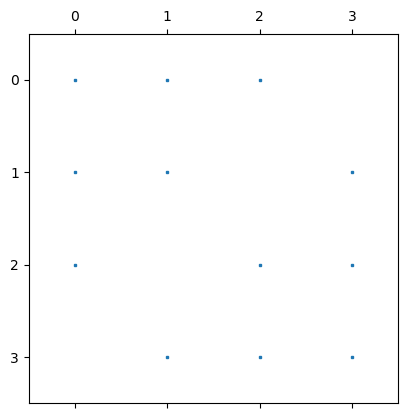

A matrix has 12 non-zero entries out of 16 (25.0% sparsity)


In [8]:
# Now we can create a spy plot to see the non-zero values of the A matrix

plt.spy(A_mat, markersize=2, aspect='equal')
plt.show()

print('A matrix has {} non-zero entries out of {} ({:.1f}% sparsity)'.format
      (A_mat.nnz,N**2,(1-A_mat.nnz/(N**2))*100))

# We can also convert the sparse matrix to the original full matrix - Uncomment below
# print(A_mat.toarray())

### 4) Solve the laplace equation using the bi-conjugate gradient stabilised matrix solver (BiCGStab)

In [9]:
# Use the bicgstab solver

x_vec, info = LA.bicgstab(A_mat,b_vec,tol=0.5e-12)

# The x_vec is a vector. We need to unpack its values in the correct positions in the 2D grid

for j in range(1, nj-1):
    for i in range(1, ni-1):
        k = (i-1) + (ni-2)*(j-1)
        u[j,i]=x_vec[k]

### 5) Finally, plot the solution

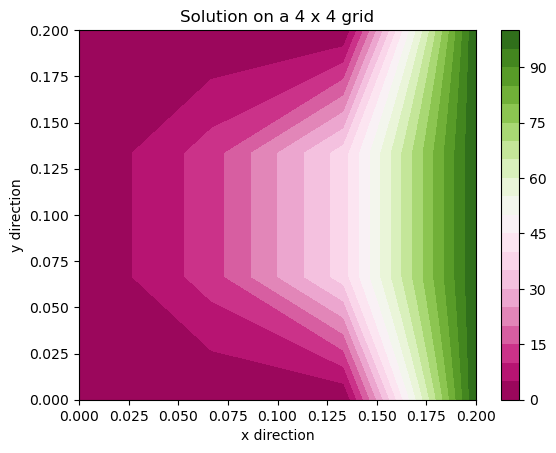

In [10]:
# Create figure and add a plot to it
fig, ax1 = plt.subplots()

# Set colormap
cmap = plt.get_cmap('PiYG')

# Create contour plot
cf = ax1.contourf(x, y, u, cmap=cmap, levels = 21)

# Set colorbar
fig.colorbar(cf, ax=ax1)

# Set title
ax1.set_title(f'Solution on a {ni} x {nj} grid')

# Set axis labels
ax1.set_xlabel('x direction')
ax1.set_ylabel('y direction')

plt.show()

### Now try with different grid size!

If a grid size of $30 \times 30$ is used, then the A matrix will have 3808 non-zero entries out of 614656, which means that $\approx$ 99.4% of the A matrix is zero, and thus justifies the use of a sparse matrix, which requires significantly less storage.